In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.naive_bayes import *
from sklearn.ensemble import *
from sklearn.preprocessing import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%pylab inline
plt.style.use('ggplot')

pd.set_option('display.max_colwidth', 999)

Populating the interactive namespace from numpy and matplotlib


# Baseline Model

In [12]:
# turn date column into a datetime data type
df['last_trip_date'] = pd.to_datetime(df['last_trip_date']) 

In [13]:
# Quick feature engineering 
# LTV: Life time value - forged by multiplying average surge, the first trip in first thirty days and the average distance of the users 


df['LTV']=df['avg_surge']*df['trips_in_first_30_days']*df['avg_dist']
df['miles']=df['trips_in_first_30_days']*df['avg_dist']
df['avg_ride_price']=df['avg_surge']*df['avg_dist']

In [14]:
df.avg_dist[df.avg_dist>40]=40

/Users/Haebichan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
# Set out own target to turn unsupervised problem into a supervised one The target will be all the users who haven't used a ride share platform before 2014-06-01. In other words, if users haven't used the app in a certain amount of time, we will consider them no longer users of the app.

df['target'] = (df['last_trip_date'] < '2014-06-01') * 1
df['constant'] = 1

In [16]:
# Train and split your data
x_train, x_test, y_train, y_test = train_test_split(df.drop('target',axis=1), df['target'], test_size = 0.3)

In [17]:
x_train_baseline = pd.DataFrame(x_train[['luxury_car_user', 'trips_in_first_30_days']])#.join(df['constant'])

In [18]:
# Simple Logistic Regression as baseline model

model = LogisticRegression()
model.fit(x_train_baseline, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
x_test_baseline = pd.DataFrame(x_test[['luxury_car_user', 'trips_in_first_30_days']])#.join(df['constant'])
y_pred = model.predict(x_test_baseline)

In [24]:
# Confusion matrix to measure our false positives and true negatives

confusion_matrix(y_pred, y_test)

array([[1174,  554],
       [3310, 6962]])

In [25]:
print('precision score: {}'.format(precision_score(y_pred, y_test)))
print('recall score: {}'.format(recall_score(y_pred, y_test)))
print('accuracy score: {}'.format(accuracy_score(y_pred, y_test)))


precision score: 0.9262905800957957
recall score: 0.6777647975077882
accuracy score: 0.678


# Deep Dive into the Data + basic feature engineering

In [27]:
# Looking at correlation of feature variables with the target
df.corr()['target'].sort_values()

trips_in_first_30_days         -0.210677
luxury_car_user                -0.206902
LTV                            -0.139029
miles                          -0.136958
surge_pct                      -0.011551
weekday_pct                    -0.008383
avg_surge                       0.003146
avg_rating_of_driver            0.012902
avg_rating_by_driver            0.027461
avg_rating_of_driver_imputed    0.041909
avg_dist_log                    0.052374
avg_ride_price                  0.092459
avg_dist                        0.095971
target                          1.000000
constant                             NaN
Name: target, dtype: float64

In [28]:
df['luxury_car_user'] = df['luxury_car_user'] * 1

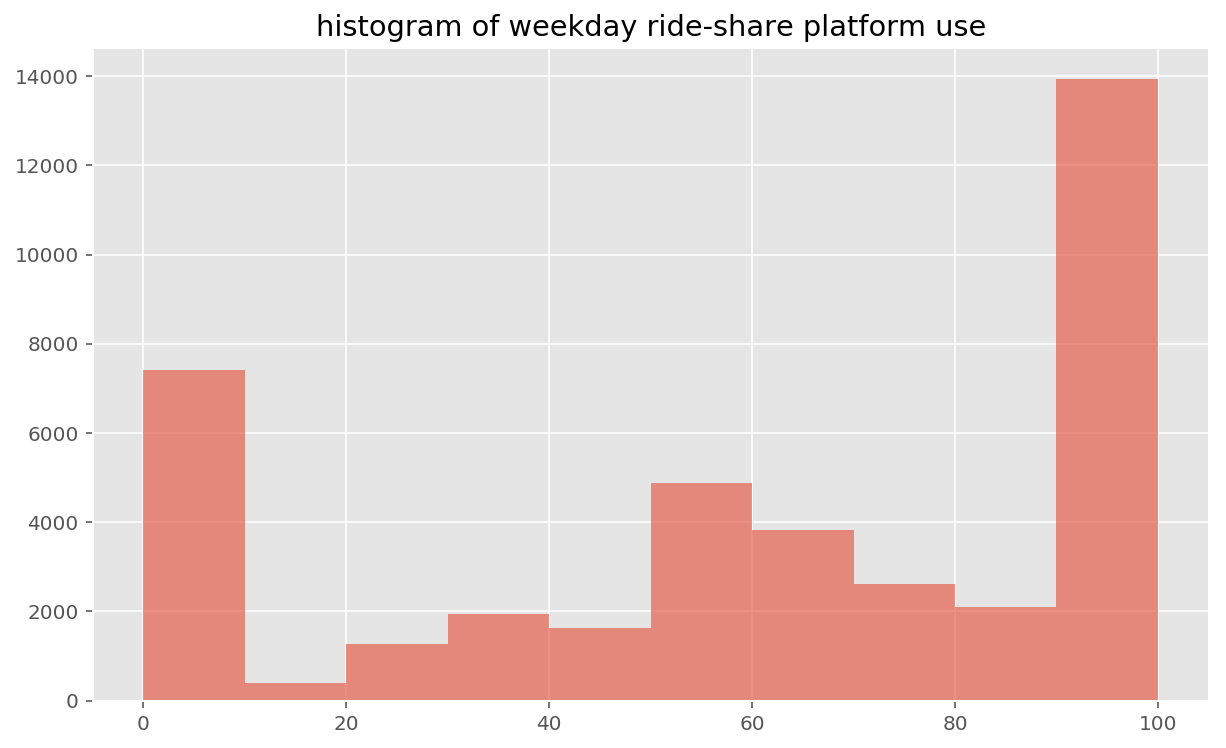

In [35]:
figure = figsize(10,6)
hist(df.weekday_pct, alpha = 0.6);
title('histogram of weekday ride-share platform use');


/Users/Haebichan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))
/Users/Haebichan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


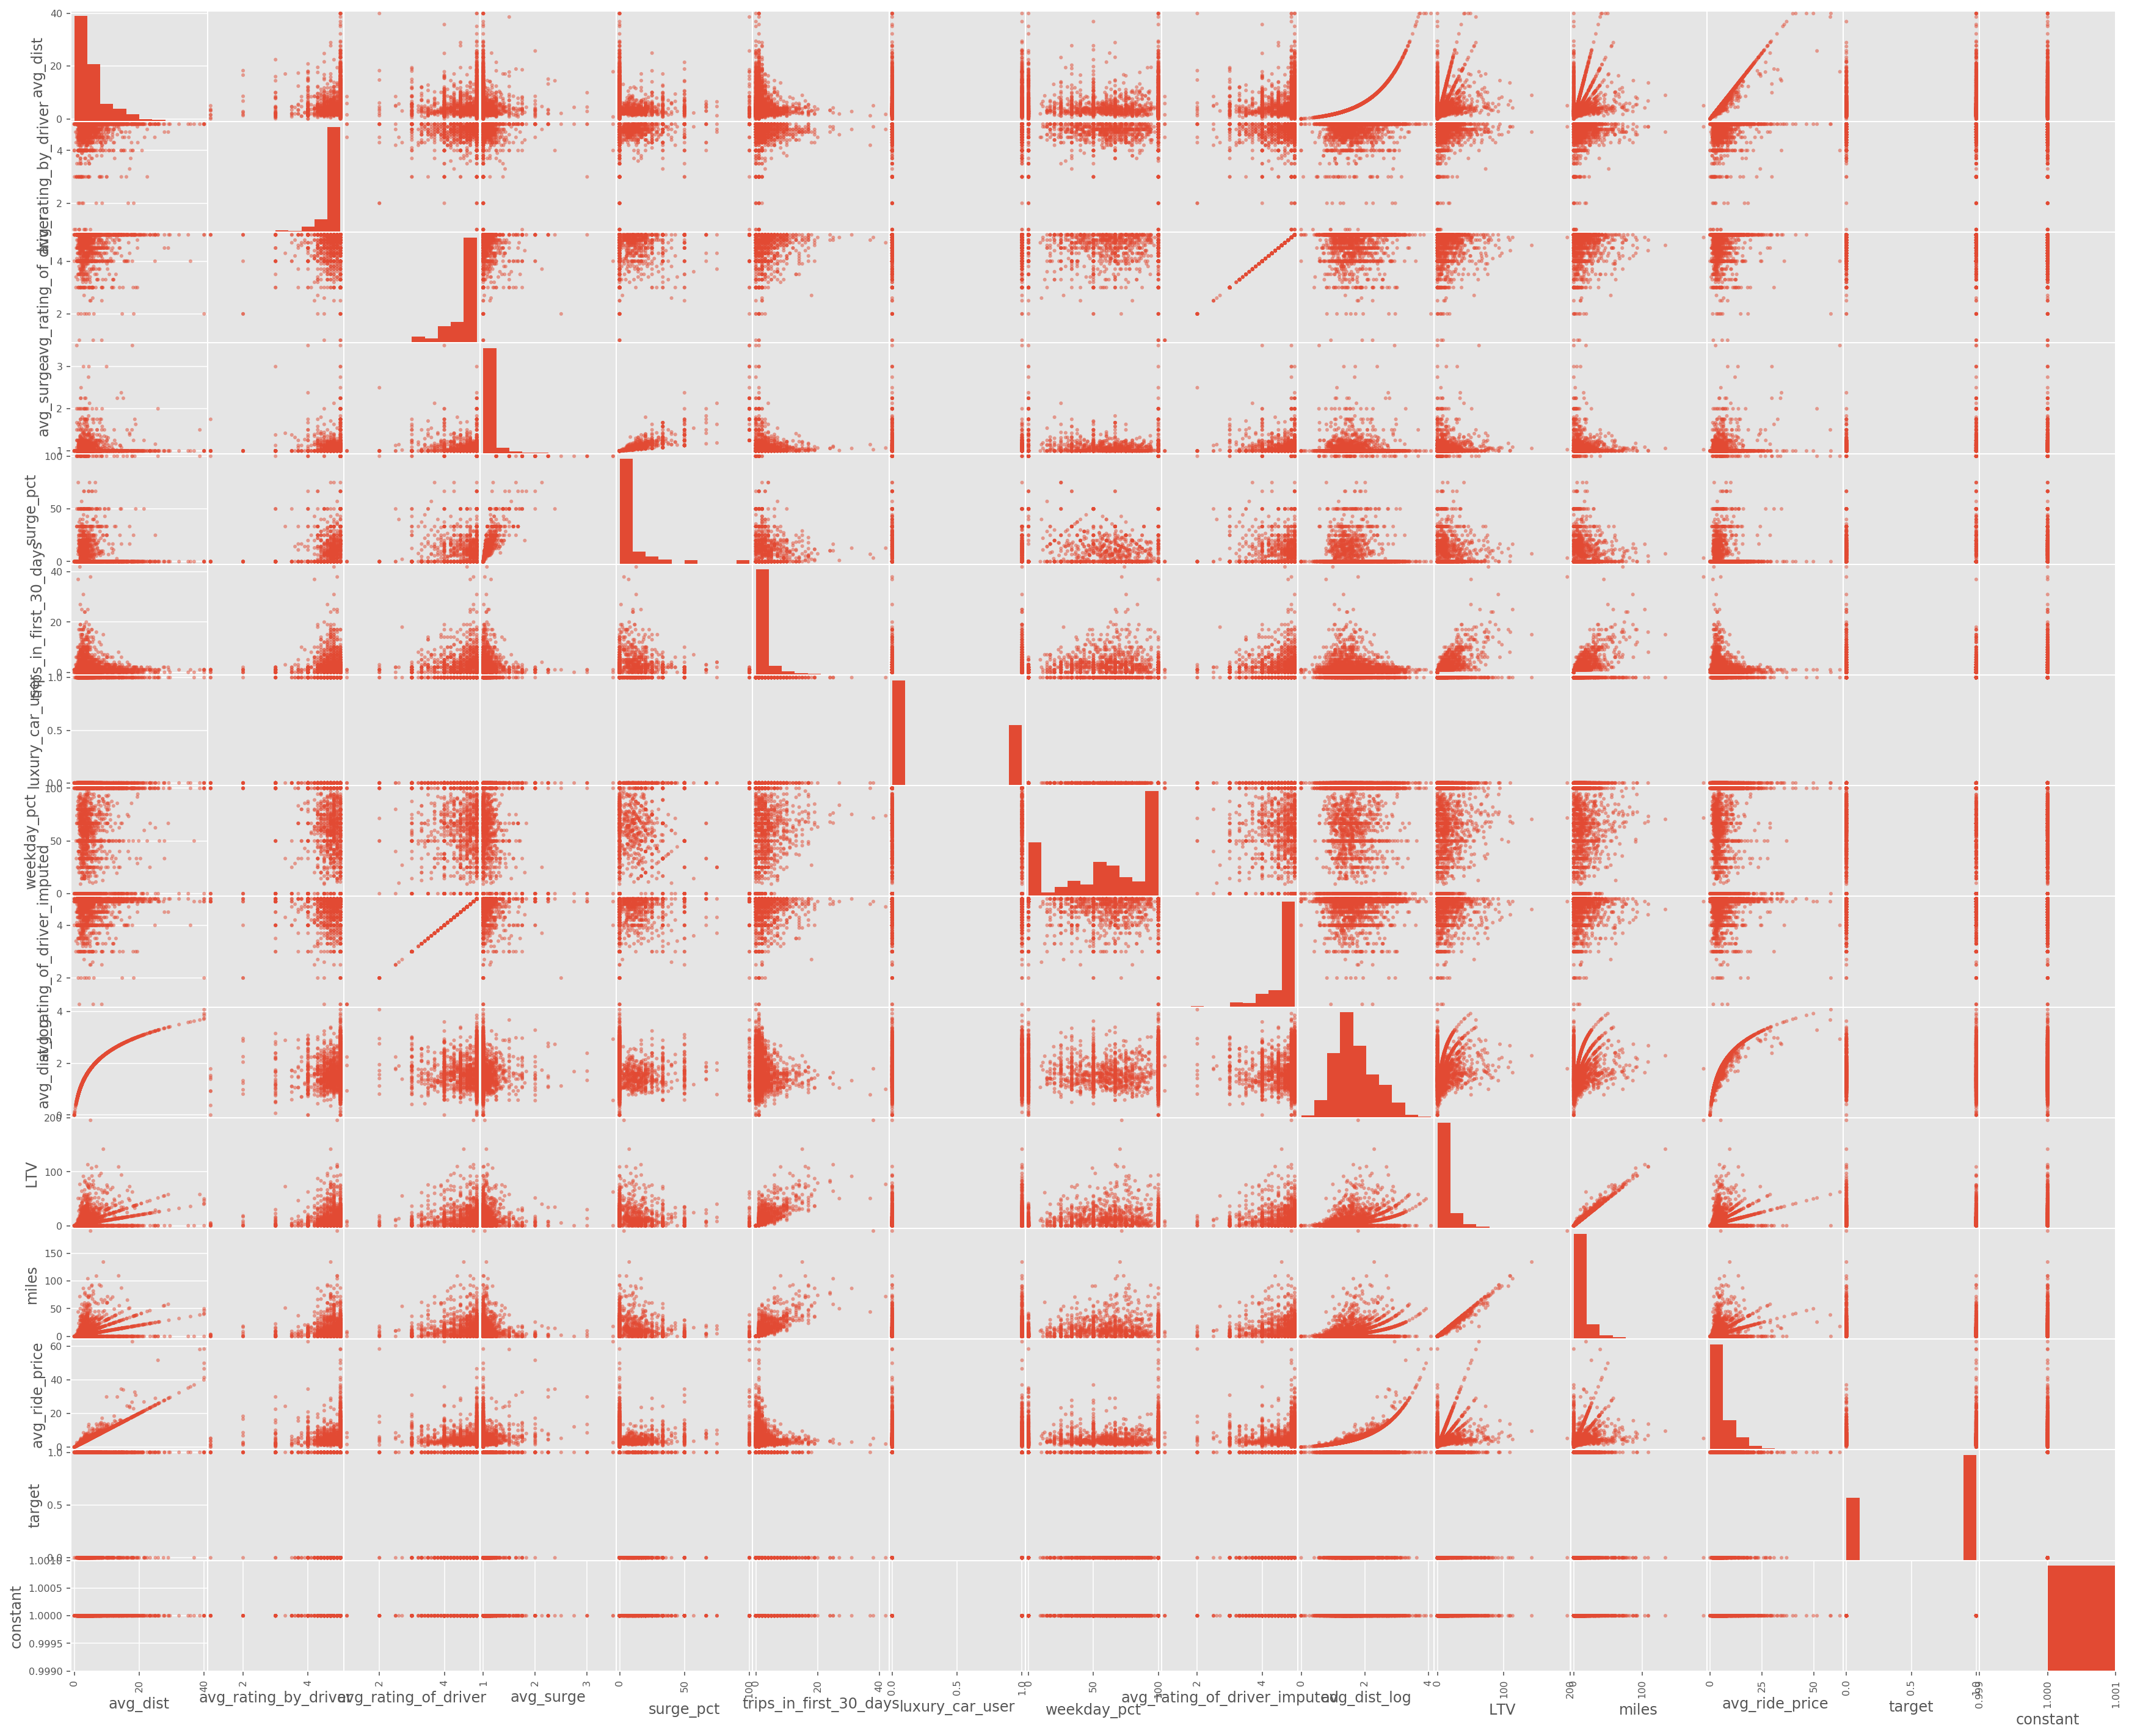

In [37]:
# Scatter matrix to show collinearity of feature variables with numeric data 
figure = figsize(30,25)
pd.plotting.scatter_matrix(df._get_numeric_data().sample(2000));

In [39]:
# checking out the correlation of average rating by driver and of driver
df['avg_rating_by_driver avg_rating_of_driver'.split()].corr()

,avg_rating_by_driver,avg_rating_of_driver
avg_rating_by_driver,1.000000,0.118703
avg_rating_of_driver,0.118703,1.000000


In [40]:
x_train['luxury_car_user'] = (x_train['luxury_car_user'] == 0) * 1

In [41]:
# baseline features once more

featurez=['constant','luxury_car_user', 'trips_in_first_30_days']

In [42]:
x_train_baseline = pd.DataFrame(x_train[featurez])#.join(df['constant'])

In [50]:
def logit_model(X_train,y_train,X_test,y_test,featurez):
    x_train_baseline = pd.DataFrame(x_train[featurez])
    x_test_baseline = pd.DataFrame(x_test[featurez])
    model = LogisticRegression()
    model.fit(x_train_baseline, y_train)
    y_pred = model.predict(x_test_baseline)
    print("accuracy i : "+ str(accuracy_score(y_pred, y_test)))
    print("precision i : "+ str(precision_score(y_pred, y_test)))
    print("recall i : "+ str(recall_score(y_pred, y_test)))
    

    fig,ax = plt.subplots(1,2, figsize = (10,10))    
    
    y_pred_prob = model.predict_proba(x_test_baseline)[:,1]
    fpr, tpr, all_thresholds = roc_curve(y_test, y_pred_prob)


    ax[0].hist(y_pred_prob, bins = 20)
    ax[1].plot(fpr,tpr)
    
    title('histogram and ROC Curve for model evaluation')
    grid(True)

accuracy i : 0.6286666666666667
precision i : 0.8641564662054284
recall i : 0.6540785498489426


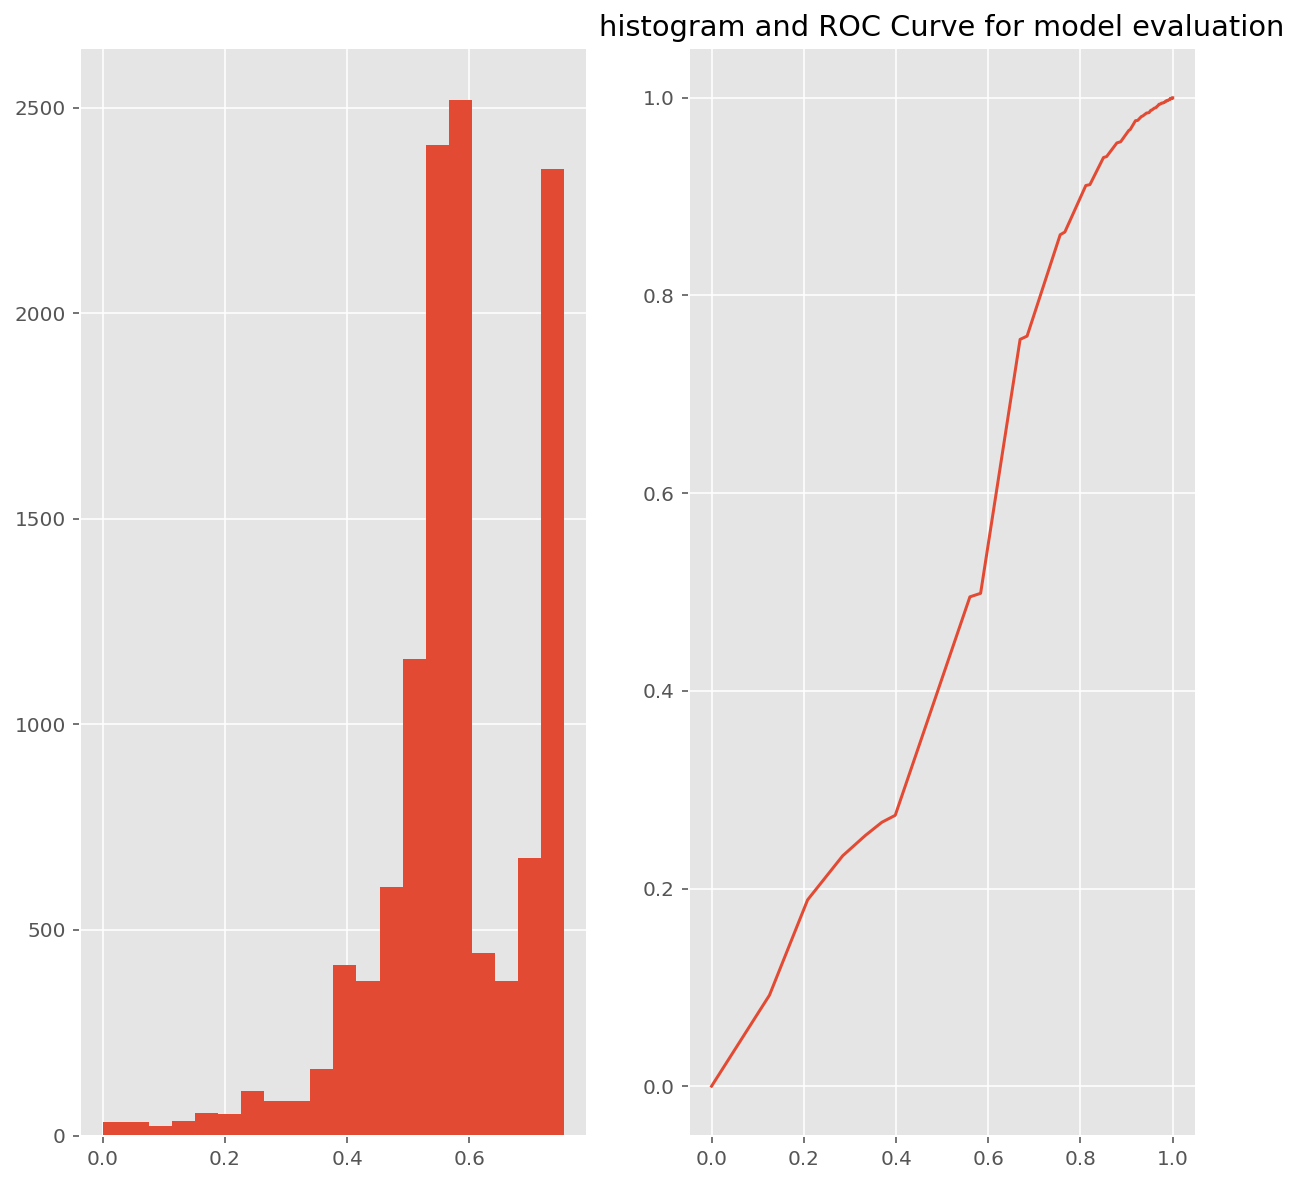

In [51]:
logit_model(x_train,y_train,x_test,y_test,featurez)

# Upgrading our model through heavier feature engineering / feature selection 

In [121]:
#Load data and transform a date-related column to datetime type

df= pd.read_csv('data/churn_train.csv')
df['last_trip_date'] = pd.to_datetime(df['last_trip_date']) 

test_df= pd.read_csv('data/churn_test.csv')
test_df['last_trip_date'] = pd.to_datetime(test_df['last_trip_date']) 

In [95]:
# Create a logistic regression classifier

def logit_model(X_train,y_train,X_test,y_test,featurez):
    x_train_baseline = pd.DataFrame(x_train[featurez])
    x_test_baseline = pd.DataFrame(x_test[featurez])
    model = LogisticRegression()
    model.fit(x_train_baseline, y_train)
    y_pred = model.predict(x_test_baseline)
    print("accuracy i : "+ str(accuracy_score(y_pred, y_test)))
    print("precision i : "+ str(precision_score(y_pred, y_test)))
    print("recall i : "+ str(recall_score(y_pred, y_test)))
    

    fig,ax = plt.subplots(1,2, figsize = (5,5))    
    
    y_pred_prob = model.predict_proba(x_test_baseline)[:,1]
    fpr, tpr, all_thresholds = roc_curve(y_test, y_pred_prob)


    ax[0].hist(y_pred_prob, bins = 20)
    ax[1].plot(fpr,tpr)
    
    title('ROC Curve for Churn Prediction')
    grid(True)

In [137]:
# Create a logistic regression classifier

def logit_model2(X_train,y_train,X_test,y_test,featurez):
    for i in featurez:
        x_train_baseline = pd.DataFrame(x_train[i])
        x_test_baseline = pd.DataFrame(x_test[i])
        model = LogisticRegression()
        model.fit(x_train_baseline, y_train)
        y_pred = model.predict(x_test_baseline)
        print(i)
        print("accuracy: "+  str(accuracy_score(y_pred, y_test)))
        print("precision: "+  str(precision_score(y_pred, y_test)))
        print("recall: "+  str(recall_score(y_pred, y_test)))




# Feature Engineering 

In [122]:
# LTV: Life time value - forged by multiplying average surge, the first trip in first thirty days and the average distance of the users 

# apply same transformations to test data without causing data leakage 

df['LTV']=df['avg_surge']*df['trips_in_first_30_days']*df['avg_dist']
df['miles']=df['trips_in_first_30_days']*df['avg_dist']
df['avg_ride_price']=df['avg_surge']*df['avg_dist']

test_df['LTV']=test_df['avg_surge']*test_df['trips_in_first_30_days']*test_df['avg_dist']
test_df['miles']=test_df['trips_in_first_30_days']*test_df['avg_dist']
test_df['avg_ride_price']=test_df['avg_surge']*test_df['avg_dist']

In [123]:
# Turn unsupervised problem into a supervised one by designing a personalized target value. The target will be all the users who haven't used a ride share platform before 2014-06-01. In other words, if users haven't used the app in a certain amount of time, we will consider them no longer users of the app.

df['target'] = (df['last_trip_date'] < '2014-06-01') * 1
df['constant'] = 1
df['luxury_car_user'] = (df['luxury_car_user'] == 0) * 1


test_df['target'] = (test_df['last_trip_date'] < '2014-06-01') * 1
test_df['constant'] = 1
test_df['luxury_car_user'] = (test_df['luxury_car_user'] == 0) * 1

In [124]:
# Imputing Nan Values

df['avg_rating_of_driver_imputed'] = df['avg_rating_of_driver'].fillna(df.avg_rating_of_driver.median())
test_df['avg_rating_of_driver_imputed'] = test_df['avg_rating_of_driver'].fillna(df.avg_rating_of_driver.median())

In [125]:
# Dummify the city column, as different cities might have different user behaviors and thus carry independent signals. Drop one column to solve extra rank issue when using linear models. 

df = df.join(pd.get_dummies(df['city']).join(df['target']).drop(['Winterfell','target'], 1))
df = df.join(pd.get_dummies(df['phone'], drop_first = True))

test_df = test_df.join(pd.get_dummies(test_df['city']).join(test_df['target']).drop(['Winterfell','target'], 1))
test_df = test_df.join(pd.get_dummies(test_df['phone'], drop_first = True))

In [127]:
# Apply logarithmic transformations to offset skewed distributions in features

df['avg_dist_log'] = np.log(1 + df['avg_dist'])
df['avg_ride_price_log'] = np.log(1 + df['avg_ride_price'])
df['avg_surge_log'] = np.log(1 + df['avg_surge'])
df['LTV_log'] = df['avg_surge_log']*df['trips_in_first_30_days']*df['avg_dist_log']
df['surge_pct_log'] = np.log(1 + df['surge_pct'])
df['weekday_pct_log'] = np.log(1 + df['weekday_pct'])
df['miles_log'] = np.log(1 + df['miles'])



test_df['avg_dist_log'] = np.log(1 + test_df['avg_dist'])
test_df['avg_ride_price_log'] = np.log(1 + test_df['avg_ride_price'])
test_df['avg_surge_log'] = np.log(1 + test_df['avg_surge'])
test_df['LTV_log'] = test_df['avg_surge_log']*test_df['trips_in_first_30_days']*test_df['avg_dist_log']
test_df['surge_pct_log'] = np.log(1 + test_df['surge_pct'])
test_df['weekday_pct_log'] = np.log(1 + test_df['weekday_pct'])
test_df['miles_log'] = np.log(1 + test_df['miles'])

In [128]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target',axis=1), df['target'], test_size = 0.3)

In [129]:
# Trying out different features. Measured whether the score went up based on feature addition. Next time will do a more complex feature engineering technique such as filtering or wrapping methods 

model0 = ['constant','luxury_car_user']
model1 = ['constant','luxury_car_user', 'trips_in_first_30_days']
model2 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV']
model3 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles']
model4 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price']
model5 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price', 'avg_rating_of_driver_imputed']

model6 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price', 'avg_rating_of_driver_imputed', "Astapor", "King's Landing"]
model7 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone']
model8 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log']
model9 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log']
model10 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log','surge_pct', 'weekday_pct']
model11 = ['constant','luxury_car_user', 'LTV','trips_in_first_30_days', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log','surge_pct', 'weekday_pct', 'surge_pct_log']
model12 = ['constant','luxury_car_user', 'LTV','trips_in_first_30_days', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log', 'weekday_pct', 'surge_pct_log', 'surge_pct']
model13 = ['constant','luxury_car_user', 'LTV','trips_in_first_30_days', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log', 'weekday_pct', 'surge_pct_log', 'surge_pct', 'weekday_pct_log']
model14 = ['constant','luxury_car_user', 'LTV','trips_in_first_30_days', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log', 'weekday_pct', 'surge_pct_log', 'surge_pct', 'weekday_pct_log', 'miles_log']

model15 = ['constant','luxury_car_user', 'trips_in_first_30_days', 'weekday_pct', 'iPhone','surge_pct', "King's Landing", 'Astapor']
model16 = ['luxury_car_user', 'LTV','trips_in_first_30_days', 'miles', 'avg_ride_price_log', 'avg_rating_of_driver_imputed','Astapor', "King's Landing", 'iPhone', 'LTV_log', 'weekday_pct', 'surge_pct_log', 'surge_pct', 'weekday_pct_log']

features_list =[model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16]

In [130]:
y = df.target
# df.drop('target', 1, inplace = True)

In [84]:
model2 = RandomForestClassifier(n_estimators= 36, min_samples_split= 18, min_samples_leaf = 24, max_depth = 15)
# model2 = RandomForestClassifier(n_estimators= 29, min_samples_split = 32, min_samples_leaf = 6, max_depth =  14)

model2.fit(df[model13], y);


In [85]:
test_y = test_df.target
test_df.drop('target',1,inplace = True)

In [86]:
y_pred = model2.predict(test_df[model13])

In [87]:
y_pred_prob = model2.predict_proba(test_df[model13])[:,1]

In [88]:
print('Precision score', precision_score(test_y, y_pred))
print('Recall score',recall_score(test_y, y_pred))
print('Accuracy score',accuracy_score(test_y, y_pred))
print('AUC score', roc_auc_score(test_y, y_pred_prob))
print('Confusion Matrix\n', confusion_matrix(test_y, y_pred))

Precision score 0.7930215293244246
Recall score 0.8575786769428388
Accuracy score 0.7719
AUC score 0.8415938206410212
Confusion Matrix
 [[2378 1394]
 [ 887 5341]]


In [138]:
# model13 gives us the highest score for all three measurements
logit_model2(x_train,y_train,x_test,y_test,features_list)

['constant', 'luxury_car_user']
accuracy: 0.6303333333333333
precision: 0.703209615638621
recall: 0.7086383601756955
['constant', 'luxury_car_user', 'trips_in_first_30_days']
accuracy: 0.6829166666666666
precision: 0.9292035398230089
recall: 0.6827445652173914
['constant', 'luxury_car_user', 'trips_in_first_30_days', 'LTV']
accuracy: 0.6803333333333333
precision: 0.9203539823008849
recall: 0.6830702872267425
['constant', 'luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles']
accuracy: 0.6826666666666666
precision: 0.9225993924184388
recall: 0.6843342803958068
['constant', 'luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price']
accuracy: 0.6848333333333333
precision: 0.9120327565711267
recall: 0.6890529887236803
['constant', 'luxury_car_user', 'trips_in_first_30_days', 'LTV', 'miles', 'avg_ride_price', 'avg_rating_of_driver_imputed']
accuracy: 0.6818333333333333
precision: 0.9047681944260996
recall: 0.6886498441741229
['constant', 'luxury_car_user', 'trips_i

In [139]:
# Model Optimization 

n_estimators_range = range(1,50)
min_samples_split_range = range(2,50)
min_samples_leaf_range = range(2,50)
max_depth_range = range(1,20)

param_grid = dict({
    'n_estimators': n_estimators_range,
    'min_samples_split': min_samples_split_range,
    'min_samples_leaf': min_samples_leaf_range,
    'max_depth': max_depth_range,
})

search = RandomizedSearchCV(model, param_grid, cv = 10, scoring = 'accuracy')
search.fit(x_train[model13], y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=24, min_samples_split=18,
            min_weight_fraction_leaf=0.0, n_estimators=36, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': range(1, 50), 'min_samples_split': range(2, 50), 'min_samples_leaf': range(2, 50), 'max_depth': range(1, 20)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [140]:
print(search.best_score_)
print(search.best_params_)
print(search.best_estimator_)

0.7792142857142857
{'n_estimators': 44, 'min_samples_split': 19, 'min_samples_leaf': 22, 'max_depth': 12}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=22, min_samples_split=19,
            min_weight_fraction_leaf=0.0, n_estimators=44, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [141]:
# Create an optmized model using found parameters

model2 = RandomForestClassifier(n_estimators= 36, min_samples_split= 18, min_samples_leaf = 24, max_depth = 15)
# model2 = RandomForestClassifier(n_estimators= 29, min_samples_split = 32, min_samples_leaf = 6, max_depth =  14)

model2.fit(x_train[model13], y_train);


In [142]:
y_pred = model2.predict(x_test[model13])

In [143]:
print('Precision score', precision_score(y_test, y_pred))
print('Recall score',recall_score(y_test, y_pred))
print('Accuracy score',accuracy_score(y_test, y_pred))
print('Confusion Matrix\n', confusion_matrix(y_test, y_pred))

Precision score 0.8054254007398274
Recall score 0.8627658169330339
Accuracy score 0.7819166666666667
Confusion Matrix
 [[2851 1578]
 [1039 6532]]


In [147]:
# Trying boosting methods to see if they perform as well as bagging-based ones 

adaboost = AdaBoostClassifier()
adaboost.fit(x_train[model13], y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [148]:
# model optimization 
n_estimators_range = range(1,50)
learning_rate_range = list(np.arange(0.1,1,0.1))

param_grid = dict({
    'n_estimators': n_estimators_range,
    'learning_rate': learning_rate_range,
})

search = RandomizedSearchCV(adaboost, param_grid, cv = 10, scoring = 'accuracy')
search.fit(x_train[model13], y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': range(1, 50), 'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [151]:
print(search.best_score_)
print(search.best_params_)
print(search.best_estimator_)

0.7703571428571429
{'n_estimators': 35, 'learning_rate': 0.9}
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.9, n_estimators=35, random_state=None)


In [150]:
# Gradient Boosting 

GB = GradientBoostingClassifier()
GB.fit(df[model13], y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [153]:
n_estimators_range = range(1,50)
learning_rate_range = list(np.arange(0.1,1,0.1))

param_grid = dict({
    'n_estimators': n_estimators_range,
    'learning_rate': learning_rate_range,
})

search = RandomizedSearchCV(GB, param_grid, cv = 10, scoring = 'accuracy')
search.fit(df[model13], y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': range(1, 50), 'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [154]:
print(search.best_score_)
print(search.best_params_)
print(search.best_estimator_)

0.78455
{'n_estimators': 36, 'learning_rate': 0.6}
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=36,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [158]:
GB = GradientBoostingClassifier(n_estimators= 36, learning_rate = 0.6)
GB.fit(df[model13], y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.6, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=36,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [159]:
y_pred = GB.predict(test_df[model13])

In [160]:
print('Precision score', precision_score(test_y, y_pred))
print('Recall score',recall_score(test_y, y_pred))
print('Accuracy score',accuracy_score(test_y, y_pred))
print('Confusion Matrix\n', confusion_matrix(test_y, y_pred))

Precision score 0.7944064266587325
Recall score 0.8574181117533719
Accuracy score 0.773
Confusion Matrix
 [[2390 1382]
 [ 888 5340]]
